In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import numpy as np
import pandas as pd

In [39]:
train_folder = 'data/train_/'
test_folder = 'data/test_/'
data_folder = 'data/'
random_subset = 10

In [40]:
files = !ls {train_folder}
files = np.array(files)
n = len(files)

Text(0.5,1,'resized')

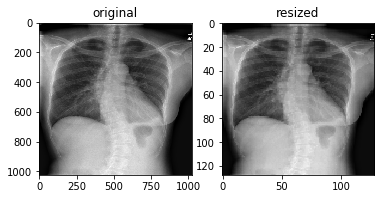

In [41]:
img = cv2.imread(f'{train_folder}{files[10]}',1)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
img2 = cv2.resize(img,(128,128))
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('resized')

In [42]:
idx = np.random.choice(n,size=(random_subset,),replace=False)
for i, _ in enumerate(files[idx]):
    img = cv2.imread(f'{train_folder}{files[i]}',1)
    # all channels are same
    assert (np.logical_and( (img[:,:,0]==img[:,:,1]).all(), (img[:,:,1]==img[:,:,2]).all()) == True )

In [43]:
labels_tr = pd.read_csv(f'{data_folder}train.csv')
labels_tr.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [44]:
labels_tr.isnull().values.any() #no null values

False

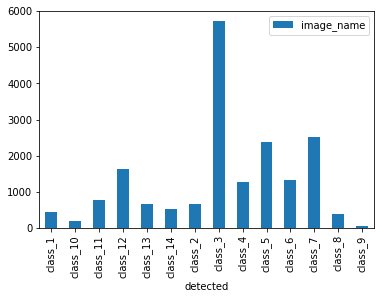

In [45]:
classes = pd.Series(['class_1','class_2', 'class_3', 'class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13','class_14',])
labels_tr.groupby('detected').count().reset_index().plot(kind='bar', x='detected',y='image_name')

In [46]:
rdc = labels_tr.groupby(['gender','detected']).count()


In [47]:
F = rdc.loc['F']
M = rdc.loc['M']
M

,row_id,age,view_position,image_name
detected,,,,
class_1,240,240,240,240
class_10,119,119,119,119
class_11,464,464,464,464
class_12,921,921,921,921
class_13,388,388,388,388
class_14,335,335,335,335
class_2,306,306,306,306
class_3,3230,3230,3230,3230
class_4,776,776,776,776


In [48]:
(M.index == F.index).any()

True

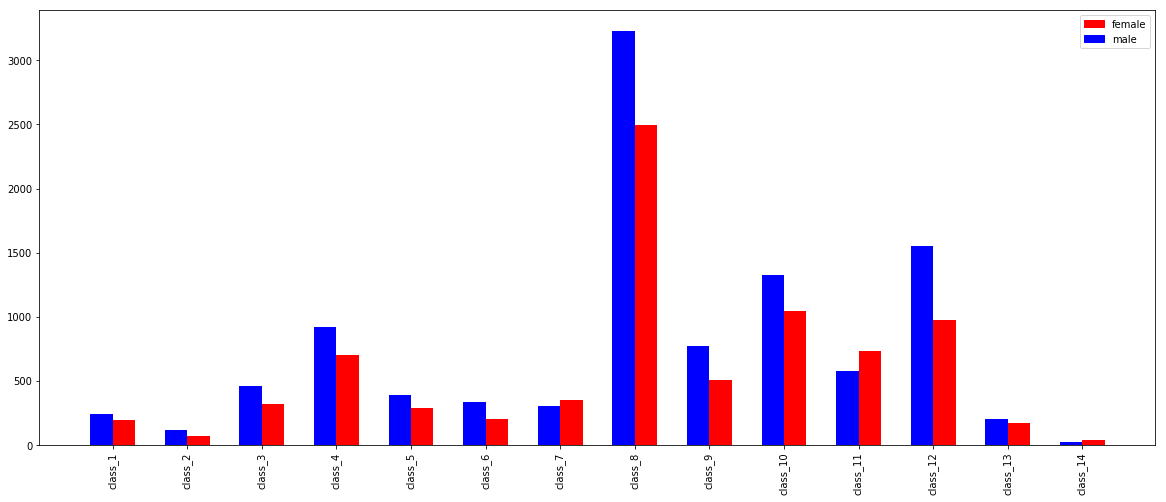

In [49]:
plt.figure(figsize = (20,8))
red_patch = mpatches.Patch(color='red', label='female')
blue_patch = mpatches.Patch(color='blue', label='male')
ax = plt.subplot(111)
plt.xticks(np.arange(len(classes)), classes, rotation=90)
ax.bar(np.arange(len(classes)) - 0.3, M['age'],width=0.3,color='b',align='edge')
ax.bar(np.arange(len(classes)), F['age'],width=0.3,color='r',align='edge')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

In [50]:
files = labels_tr['image_name']
files[:10]

0        scan_0000.png
1        scan_0001.png
2       scan_00010.png
3     scan_0001000.png
4    scan_00010000.png
5    scan_00010001.png
6    scan_00010003.png
7    scan_00010004.png
8    scan_00010006.png
9    scan_00010007.png
Name: image_name, dtype: object

In [51]:
labels_tr.set_index('image_name').head()

,row_id,age,gender,view_position,detected
image_name,,,,,
scan_0000.png,id_0,45,M,0,class_3
scan_0001.png,id_1,57,F,0,class_3
scan_00010.png,id_10,58,M,0,class_3
scan_0001000.png,id_1000,64,M,0,class_6
scan_00010000.png,id_10000,33,M,1,class_3


In [52]:
def show_sample(img,label = None,mapping=None):
    plt.imshow(img)
    if label:
        plt.title("label={} and class_name={}".format(label,mapping[label]))

In [53]:
t = labels_tr
t.head()
# t['codes'] = t.detected.astype('category')
# for i in 
# t['codes'] = t.detected
dict(enumerate(t.detected.astype('category').cat.categories))


{0: 'class_1',
 1: 'class_10',
 2: 'class_11',
 3: 'class_12',
 4: 'class_13',
 5: 'class_14',
 6: 'class_2',
 7: 'class_3',
 8: 'class_4',
 9: 'class_5',
 10: 'class_6',
 11: 'class_7',
 12: 'class_8',
 13: 'class_9'}

## Data Loading and Transformations

In [54]:
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
import torch
import os
import PIL.Image as Image
from sklearn.model_selection import train_test_split

In [81]:
class XRayDataset(Dataset):
    
    def __init__(self, csv_file, path, transform = None,is_train=True):
        self.df = pd.read_csv(csv_file)
        self.df['detected_id'] = self.df.detected.astype('category').cat.codes
        self.path = path
        self.idx_to_classes = dict(enumerate(self.df.detected.astype('category').cat.categories))
        self.transform = transform
        
        if is_train:
            indices = np.arange(len(self.df))
            tmp,self.test_idx =  train_test_split(indices,test_size=0.2,random_state=42)
            self.tr_idx, self.val_idx = train_test_split(tmp, test_size=0.25,random_state=42)
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,idx):

        img_path = os.path.join(self.path,'train_',self.df.loc[idx,'image_name'])
        img = cv2.imread(img_path,1)
        label = self.df.loc[idx,'detected_id']
        sample = {'image':img,
                  'label':label
                 }
        
        if self.transform:
            if idx in self.val_idx or idx in self.test_idx:
                sample['image'] = self.transform['test_aug'](sample['image'])
            else:
                sample['image'] = self.transform['train_aug'](sample['image'])
            
        return sample      


0 (1024, 1024, 3) 7
1 (1024, 1024, 3) 7
2 (1024, 1024, 3) 7
3 (1024, 1024, 3) 10


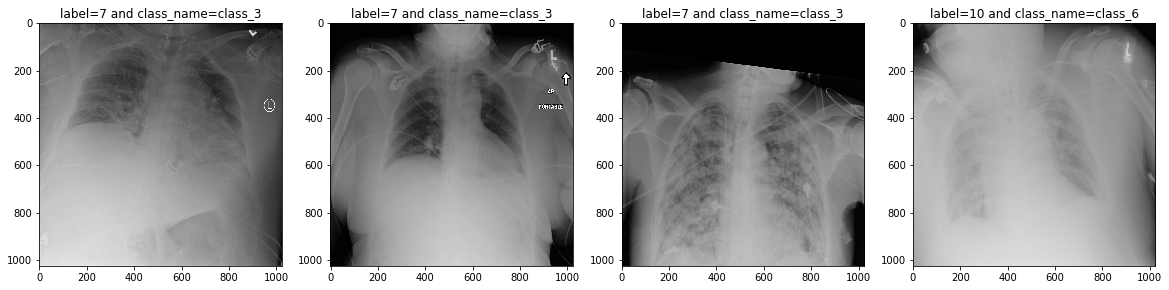

In [56]:
train_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',None)

fig = plt.figure(figsize=(20,5))


for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
    show_sample(sample['image'],sample['label'],train_dataset.idx_to_classes)

    if i == 3:
        plt.show()
        break


In [88]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

tfms = {    
    'train_aug': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((250,250)),
        transforms.RandomCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    
    'test_aug': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227,227)),
#         transforms.CenterCrop(227),
        transforms.ToTensor(),
        normalize
    ]),
    
    'no_aug' : transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize
    ])
}

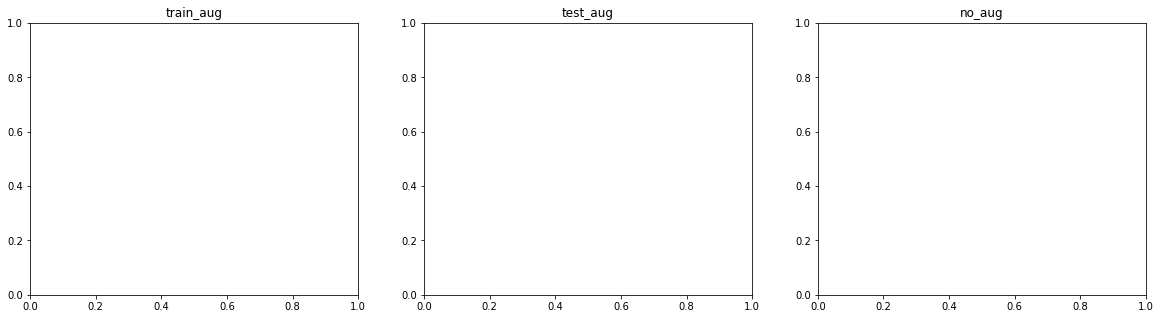

In [89]:
fig = plt.figure(figsize=(20,5))

sample = train_dataset[100]

for i,k in enumerate(tfms):
#     print(sample['image'].shape)
    tfmed = tfms[k](sample['image'])
#     print(tfmed.shape)
    
    ax = plt.subplot(1,3,i+1)
    ax.set_title(k)
#     show_sample(sample['image'].permute(1,2,0))   
    
    

In [90]:
transformed_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',transform=tfms)
print(len(transformed_dataset))
print(len(transformed_dataset.tr_idx),len(transformed_dataset.test_idx),)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i,sample['image'].size(),sample['label'])

    if i == 3:
        break

18577
11145 3716
0 torch.Size([3, 227, 227]) 7
1 torch.Size([3, 227, 227]) 7
2 torch.Size([3, 227, 227]) 7
3 torch.Size([3, 227, 227]) 10


In [91]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    num_workers = 1
else:
    num_workers = 4
    
use_gpu

True

In [92]:
train_sampler = sampler.SubsetRandomSampler(transformed_dataset.tr_idx)
val_sampler = sampler.SubsetRandomSampler(transformed_dataset.val_idx)
test_sampler = sampler.SubsetRandomSampler(transformed_dataset.test_idx)


samplers = {
    'train':train_sampler,
    'val': val_sampler,
    'test':test_sampler
}



dataloaders = {k : DataLoader(transformed_dataset,
                        batch_size=16,
                        sampler=v,
                        num_workers=num_workers,
                        pin_memory=use_gpu
                       ) for k,v in samplers.items()}


In [93]:
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, sample_batched['image'].size(),sample_batched['label'].size())
    if i_batch==3:
        break

0 torch.Size([16, 3, 227, 227]) torch.Size([16])
1 torch.Size([16, 3, 227, 227]) torch.Size([16])
2 torch.Size([16, 3, 227, 227]) torch.Size([16])
3 torch.Size([16, 3, 227, 227]) torch.Size([16])


In [95]:
from sklearn.metrics import accuracy_score, f1_score
import time
from torch import optim,nn
from torchvision import models
from torch.autograd import Variable
from tqdm import *

In [64]:
model_ft = models.resnet18(pretrained=True)
for i,param in enumerate(model_ft.parameters()):
    if i ==  10:
        break
    param.requires_grad = False
model_ft.fc = nn.Linear(2048, 14) #after avgpool the size comes out to be features 2048

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001)

# # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [96]:
dataset_sizes = {k : len(v) for k,v in samplers.items()}
dataset_sizes

{'test': 3716, 'train': 11145, 'val': 3716}

In [97]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    overall_train_losses = []
    overall_val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data['image'],data['label']
#                 inputs = inputs[:2,:,:,:]
#                 labels = labels[:2]
#                 print(inputs,labels)
#                 break
                labels = labels.type(torch.LongTensor)
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
#                 print("computed outputs")
#                 print(outputs.size())
#                 break
                _, preds = torch.max(outputs.data, 1)
#                 print(labels)
                loss = criterion(outputs, labels)
#                 print("computed loss")
                    
                # backward + optimize only if in training phase
                if phase == 'train':
#                     overall_train_losses.append(loss)
                    loss.backward()
#                     print("computed backward pass")
                    optimizer.step()
#                     print("update gradients")

#                 if phase == 'val':
#                     overall_val_losses.append(loss)

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
#                 print('batch passed')
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

#             deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                

            

                

#         print()
    torch.save(best_model_wts,f'./models/model_{best_acc}')
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,overall_train_losses,overall_val_losses



In [30]:
model_ft,_,_ = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0672 Acc: 0.3228
Epoch 1/9
----------
train Loss: 0.0625 Acc: 0.3685
Epoch 2/9
----------
train Loss: 0.0604 Acc: 0.3858
Epoch 3/9
----------
train Loss: 0.0585 Acc: 0.4066
Epoch 4/9
----------
train Loss: 0.0571 Acc: 0.4197
Epoch 5/9
----------
train Loss: 0.0563 Acc: 0.4335
Epoch 6/9
----------
train Loss: 0.0553 Acc: 0.4334
Epoch 7/9
----------
train Loss: 0.0513 Acc: 0.4733
Epoch 8/9
----------
train Loss: 0.0497 Acc: 0.4924
Epoch 9/9
----------
train Loss: 0.0490 Acc: 0.5010
val Loss: 0.0538 Acc: 0.4551
Training complete in 39m 21s


In [98]:
def change_to_cuda(model):
    if use_gpu:
        return model.cuda()
    else:
        return model       


In [110]:
new_model = models.resnet34(pretrained=True)
for i,param in enumerate(new_model.parameters()):
    if i ==  5:
        break
    param.requires_grad = False
new_model.fc = nn.Sequential(nn.Linear(2048,14))
new_model = change_to_cuda(new_model)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=0.0001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
new_model,tr_loss,val_loss = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------
train Loss: 0.1259 Acc: 0.3540
val Loss: 0.1197 Acc: 0.3862
Epoch 1/14
----------
train Loss: 0.1140 Acc: 0.4167
val Loss: 0.1173 Acc: 0.4193
Epoch 2/14
----------
train Loss: 0.1080 Acc: 0.4517
val Loss: 0.1163 Acc: 0.4090
Epoch 3/14
----------
train Loss: 0.1038 Acc: 0.4712
val Loss: 0.1115 Acc: 0.4524
Epoch 4/14
----------
train Loss: 0.0996 Acc: 0.4894
val Loss: 0.1159 Acc: 0.4330
Epoch 5/14
----------
train Loss: 0.0951 Acc: 0.5125
val Loss: 0.1121 Acc: 0.4389
Epoch 6/14
----------
train Loss: 0.0910 Acc: 0.5258
val Loss: 0.1123 Acc: 0.4370
Epoch 7/14
----------
train Loss: 0.0741 Acc: 0.6142
val Loss: 0.1124 Acc: 0.4516
Epoch 8/14
----------
train Loss: 0.0672 Acc: 0.6498
val Loss: 0.1174 Acc: 0.4583
Epoch 9/14
----------
train Loss: 0.0619 Acc: 0.6728
val Loss: 0.1209 Acc: 0.4467
Epoch 10/14
----------
train Loss: 0.0580 Acc: 0.6951
val Loss: 0.1250 Acc: 0.4411
Epoch 11/14
----------
train Loss: 0.0546 Acc: 0.7148
val Loss: 0.1301 Acc: 0.4322
Epoch 12/14
--

In [111]:
new_model.load_state_dict(torch.load('./models/model_0.4582884822389666'))

In [101]:
def predict(model, dset):
    
    model.train(False)
    overall_preds = []
    overall_labels = []
    for epoch in range(1): # lazy loop so that I do not have to change indentation
        for phase in [dset]: # lazy again

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data['image'],data['label']

                labels = labels.type(torch.LongTensor)
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                overall_preds += list(preds)
                overall_labels += list(labels.data)
                
                loss = criterion(outputs, labels)
                
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
#                 print('batch passed')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
    return overall_preds,overall_labels            

In [106]:
a,b = predict(new_model,'val')

f1_score(b,a,average='weighted')

val Loss: 0.1371 Acc: 0.4150


In [105]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=0.00001)
new_model,tr_loss,val_loss = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

Epoch 0/0
----------
train Loss: 0.0518 Acc: 0.7311
val Loss: 0.1371 Acc: 0.4150
Training complete in 5m 25s


In [125]:
dropout_model = models.resnet34(pretrained=True)
for i,param in enumerate(dropout_model.parameters()):
    if i ==  5:
        break
    param.requires_grad = False
dropout_model.fc = nn.Sequential(nn.Dropout(inplace=True),nn.Linear(2048,14))
dropout_model = change_to_cuda(dropout_model)

In [137]:
def lr_train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    overall_train_losses = []
    overall_val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data['image'],data['label']
#                 inputs = inputs[:2,:,:,:]
#                 labels = labels[:2]
#                 print(inputs,labels)
#                 break
                labels = labels.type(torch.LongTensor)
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
#                 print("computed outputs")
#                 print(outputs.size())
#                 break
                _, preds = torch.max(outputs.data, 1)
#                 print(labels)
                loss = criterion(outputs, labels)
#                 print("computed loss")
                    
                # backward + optimize only if in training phase
                if phase == 'train':
#                     overall_train_losses.append(loss)
                    loss.backward()
#                     print("computed backward pass")
                    optimizer.step()
#                     print("update gradients")



                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
#                 print('batch passed')
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'val':
                scheduler.step(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

#             deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                

            

                

#         print()
    torch.save(best_model_wts,f'./models/model_{best_acc}')
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,overall_train_losses,overall_val_losses


In [138]:
dropout_model.cuda()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, dropout_model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min',patience=1,verbose=True)
dropout_model,tr_loss,val_loss = lr_train_model(dropout_model, criterion, optimizer_ft, scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0973 Acc: 0.5015
val Loss: 0.1130 Acc: 0.4346
Epoch 1/9
----------
train Loss: 0.0925 Acc: 0.5257
val Loss: 0.1108 Acc: 0.4446
Epoch 2/9
----------
train Loss: 0.0878 Acc: 0.5515
val Loss: 0.1161 Acc: 0.4233
Epoch 3/9
----------
train Loss: 0.0839 Acc: 0.5682
Epoch     3: reducing learning rate of group 0 to 1.0000e-05.
val Loss: 0.1213 Acc: 0.4462
Epoch 4/9
----------
train Loss: 0.0687 Acc: 0.6444
val Loss: 0.1157 Acc: 0.4502
Epoch 5/9
----------
train Loss: 0.0617 Acc: 0.6803
Epoch     5: reducing learning rate of group 0 to 1.0000e-06.
val Loss: 0.1203 Acc: 0.4467
Epoch 6/9
----------
train Loss: 0.0579 Acc: 0.7020
val Loss: 0.1214 Acc: 0.4451
Epoch 7/9
----------
train Loss: 0.0562 Acc: 0.7093
Epoch     7: reducing learning rate of group 0 to 1.0000e-07.
val Loss: 0.1204 Acc: 0.4491
Epoch 8/9
----------
train Loss: 0.0558 Acc: 0.7113
val Loss: 0.1225 Acc: 0.4446
Epoch 9/9
----------
train Loss: 0.0563 Acc: 0.7108
Epoch     9: reducing learning ra